## Project overview
1. [EDA](#eda)
    - [Ratings](#ratings)
    - [Movies](#movies)
2. [Feature engineering](#fe)
4. [User clustering](#clusters)
3. [Merge data and check the features](#merge)
4. [Initial feature importances](#importance)
    - [Linear Regression](#linreg)
    - [Decision Tree Regressor](#tree)
5. [Modeling](#models)
    - [Metric choice](#metric)
    - [Random Forest](#rf)
    - [Catboost](#cat)
7. [Usage example](#example)

NB: This nav is kinda broken in Github but works when you run the notebook locally

In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
np.random.seed(3104)

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import matplotlib as mlp

mlp.rcParams['lines.linewidth'] = 5

mlp.rcParams['xtick.major.size'] = 15
mlp.rcParams['xtick.major.width'] = 2
mlp.rcParams['xtick.labelsize'] = 15
mlp.rcParams['xtick.color'] = '#4DFC2D'

mlp.rcParams['ytick.major.size'] = 15
mlp.rcParams['ytick.major.width'] = 2
mlp.rcParams['ytick.labelsize'] = 15
mlp.rcParams['ytick.color'] = '#4DFC2D'

mlp.rcParams['axes.labelsize'] = 20
mlp.rcParams['axes.titlesize'] = 20
mlp.rcParams['axes.titlecolor'] = '#ED6919'
mlp.rcParams['axes.labelcolor'] = '#ED6919'

mlp.rcParams['figure.figsize'] = (10, 6)

In [4]:
ratings = pd.read_csv('ratings.csv', sep=',').head(1000000)

ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [5]:
movies = pd.read_csv('movies.csv')

movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


<a id='eda'></a>
### Exploratory data analysis 

<a id='ratings'></a>

#### Ratings

In [6]:
ratings.timestamp = pd.to_datetime(ratings.timestamp, unit='s')


ratings.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

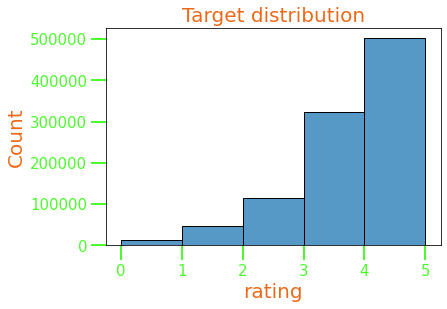

In [7]:
plt.figure(figsize=(6, 4))

sns.histplot(ratings.rating, bins=np.arange(0, 6, 1))

plt.title('Target distribution')
plt.show()

<a id='movies'></a>

#### Movies

In [8]:
movies.isna().any()

movieId    False
title      False
genres     False
dtype: bool

<a id='fe'></a>

#### Feature engineering

Add **mean rating**, **total views** and **views per day** for each user

In [9]:
ratings['mean_user_rating'] = ratings.userId.map(
    ratings.groupby('userId').rating.mean()
)

ratings.head()

,userId,movieId,rating,timestamp,mean_user_rating
0,1,2,3.5,2005-04-02 23:53:47,3.742857
1,1,29,3.5,2005-04-02 23:31:16,3.742857
2,1,32,3.5,2005-04-02 23:33:39,3.742857
3,1,47,3.5,2005-04-02 23:32:07,3.742857
4,1,50,3.5,2005-04-02 23:29:40,3.742857


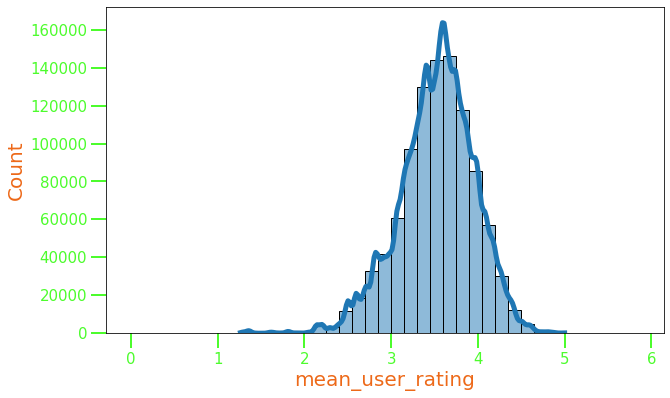

In [10]:
sns.histplot(ratings.mean_user_rating, bins=np.arange(0, 6, 0.15), kde=True)

plt.show()

In [11]:
total_views = ratings.groupby('userId').movieId.count()
ratings['total_views'] = ratings.userId.map(total_views) 

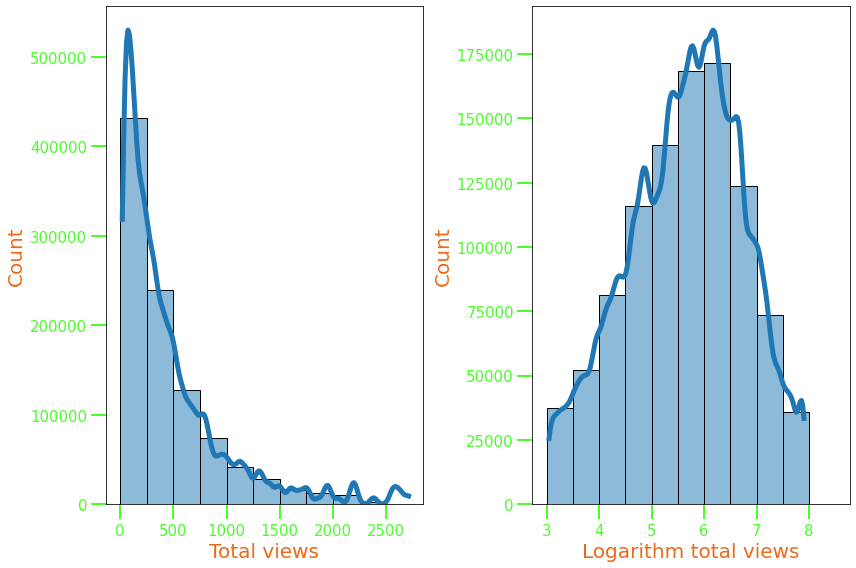

In [12]:
fig = plt.figure(figsize=(12, 8))

ax1 = fig.add_subplot(1, 2, 1)
sns.histplot(ratings.total_views, bins=np.arange(0, 2501, 250), kde=True)
plt.xlabel('Total views')


ax2 = fig.add_subplot(1, 2, 2)
sns.histplot(np.log1p(ratings.total_views), bins=np.arange(3, 9, 0.5), kde=True)
plt.xlabel('Logarithm total views')

fig.tight_layout()
plt.show()

In [13]:
ratings['first_view'] = ratings.userId.map(ratings.groupby('userId').timestamp.min())
ratings['last_view'] = ratings.userId.map(ratings.groupby('userId').timestamp.max())

ratings['total_days'] = (ratings.last_view - ratings.first_view).dt.days

ratings.head()

,userId,movieId,rating,timestamp,mean_user_rating,total_views,first_view,last_view,total_days
0,1,2,3.5,2005-04-02 23:53:47,3.742857,175,2004-09-10 03:06:38,2005-04-02 23:56:41,204
1,1,29,3.5,2005-04-02 23:31:16,3.742857,175,2004-09-10 03:06:38,2005-04-02 23:56:41,204
2,1,32,3.5,2005-04-02 23:33:39,3.742857,175,2004-09-10 03:06:38,2005-04-02 23:56:41,204
3,1,47,3.5,2005-04-02 23:32:07,3.742857,175,2004-09-10 03:06:38,2005-04-02 23:56:41,204
4,1,50,3.5,2005-04-02 23:29:40,3.742857,175,2004-09-10 03:06:38,2005-04-02 23:56:41,204


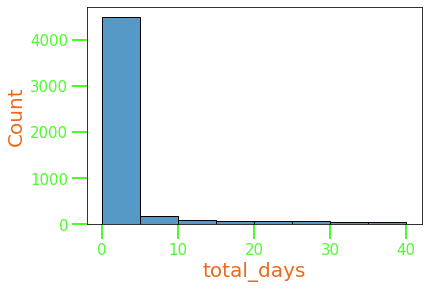

In [14]:
plt.figure(figsize=(6, 4))
sns.histplot(ratings.drop_duplicates('userId').total_days, bins=np.arange(0, 45, 5))

plt.show()

In [15]:
ratings['views_per_day'] = ratings.total_views / (ratings.total_days + 1)

ratings.head()

,userId,movieId,rating,timestamp,mean_user_rating,total_views,first_view,last_view,total_days,views_per_day
0,1,2,3.5,2005-04-02 23:53:47,3.742857,175,2004-09-10 03:06:38,2005-04-02 23:56:41,204,0.853659
1,1,29,3.5,2005-04-02 23:31:16,3.742857,175,2004-09-10 03:06:38,2005-04-02 23:56:41,204,0.853659
2,1,32,3.5,2005-04-02 23:33:39,3.742857,175,2004-09-10 03:06:38,2005-04-02 23:56:41,204,0.853659
3,1,47,3.5,2005-04-02 23:32:07,3.742857,175,2004-09-10 03:06:38,2005-04-02 23:56:41,204,0.853659
4,1,50,3.5,2005-04-02 23:29:40,3.742857,175,2004-09-10 03:06:38,2005-04-02 23:56:41,204,0.853659


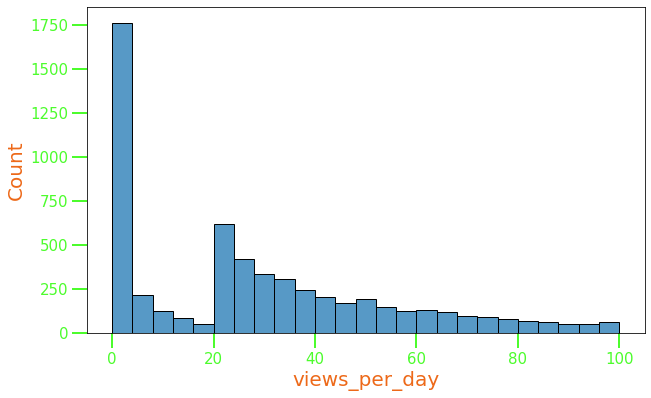

In [16]:
sns.histplot(ratings.drop_duplicates('userId').views_per_day, bins=np.arange(0, 101, 4))

plt.show()

In [17]:
ratings['log_total_views'] = ratings.total_views.apply(np.log1p)
ratings = ratings.drop(['total_views', 'total_days', 'first_view', 'last_view'], axis=1)

In [18]:
ratings.head()

,userId,movieId,rating,timestamp,mean_user_rating,views_per_day,log_total_views
0,1,2,3.5,2005-04-02 23:53:47,3.742857,0.853659,5.170484
1,1,29,3.5,2005-04-02 23:31:16,3.742857,0.853659,5.170484
2,1,32,3.5,2005-04-02 23:33:39,3.742857,0.853659,5.170484
3,1,47,3.5,2005-04-02 23:32:07,3.742857,0.853659,5.170484
4,1,50,3.5,2005-04-02 23:29:40,3.742857,0.853659,5.170484


In [19]:
ratings['year'] = ratings.timestamp.dt.year
ratings['month'] = ratings.timestamp.dt.month
ratings['weekday'] = ratings.timestamp.dt.weekday
ratings['hour'] = ratings.timestamp.dt.hour
ratings = ratings.sort_values(by='timestamp')

In [20]:
def generate_mean_ratings(column_name, ratings):
    temp_df = ratings.groupby(['userId', column_name]) \
                         .rating.mean().reset_index() \
                         .rename(columns={'rating': 'mean_' + column_name + '_rating'})

    return pd.merge(ratings, temp_df, on=['userId', column_name], how='left')

In [21]:
ratings = generate_mean_ratings('year', ratings)
ratings = generate_mean_ratings('month', ratings)
ratings = generate_mean_ratings('weekday', ratings)
ratings = generate_mean_ratings('hour', ratings)

raw_df = ratings.drop_duplicates('userId')

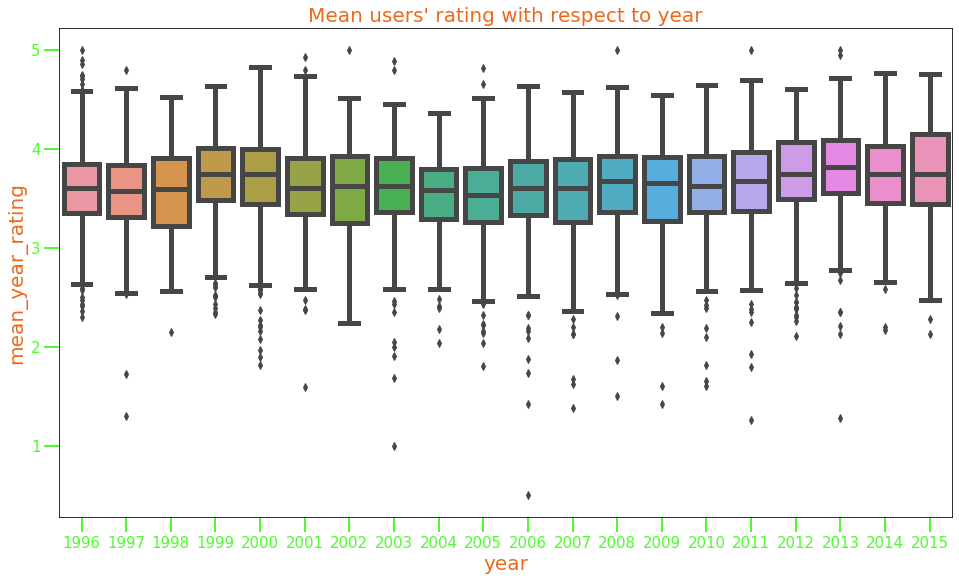

In [22]:
plt.figure(figsize=(16, 9))

sns.boxplot(x=raw_df.year, y=raw_df.mean_year_rating)

plt.title("Mean users' rating with respect to year")
plt.xticks()
plt.show()

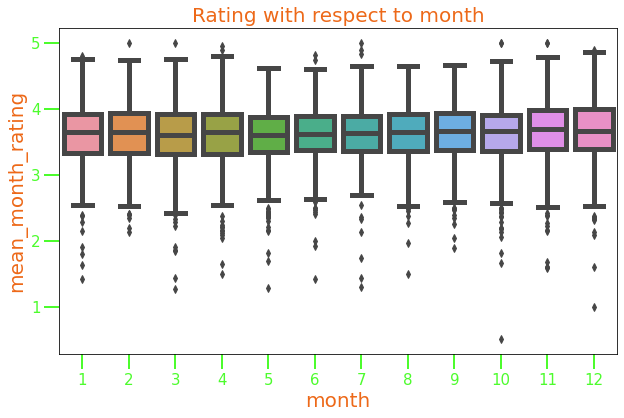

In [23]:
sns.boxplot(x=raw_df.month, y=raw_df.mean_month_rating)

plt.title('Rating with respect to month')
plt.xticks()
plt.show()

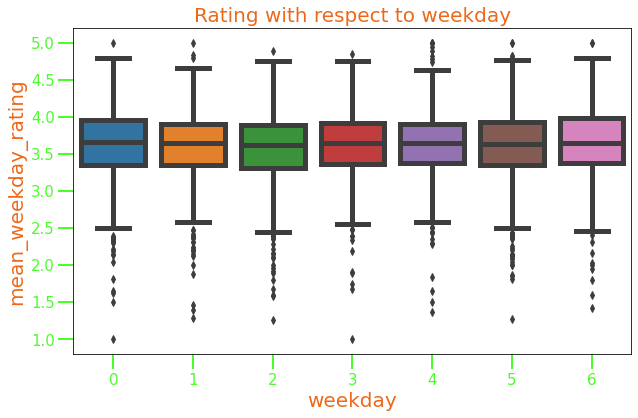

In [24]:
sns.boxplot(x=raw_df.weekday, y=raw_df.mean_weekday_rating)

plt.title('Rating with respect to weekday')
plt.xticks()
plt.show()

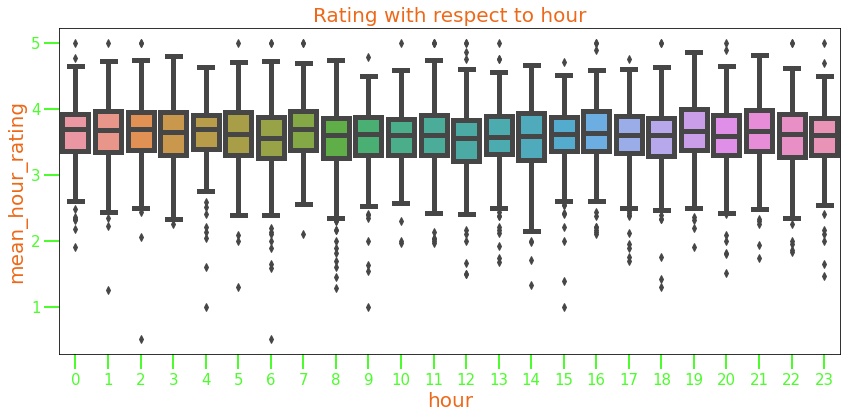

In [25]:
plt.figure(figsize=(14, 6))

sns.boxplot(x=raw_df.hour, y=raw_df.mean_hour_rating)

plt.title('Rating with respect to hour')
plt.xticks()
plt.show()

Ratings do not differ for different **month** and **weekday**, so we will drop these columns

**Year** and **hour**, though, have some detectable differences

In [26]:
ratings.columns

Index(['userId', 'movieId', 'rating', 'timestamp', 'mean_user_rating',
       'views_per_day', 'log_total_views', 'year', 'month', 'weekday', 'hour',
       'mean_year_rating', 'mean_month_rating', 'mean_weekday_rating',
       'mean_hour_rating'],
      dtype='object')

In [27]:
ratings = ratings.drop([], axis=1)

In [28]:
cols_to_drop = ['month', 'weekday', 'mean_year_rating', 
                'mean_month_rating', 'mean_weekday_rating', 'mean_hour_rating']
ratings = ratings.drop(cols_to_drop, axis=1)

ratings.head()

,userId,movieId,rating,timestamp,mean_user_rating,views_per_day,log_total_views,year,hour
0,4864,79,1.0,1996-02-28 09:32:14,3.689655,0.667519,5.568345,1996,9
1,4864,17,5.0,1996-02-28 09:32:14,3.689655,0.667519,5.568345,1996,9
2,4864,10,3.0,1996-02-28 09:32:14,3.689655,0.667519,5.568345,1996,9
3,4864,11,5.0,1996-02-28 09:32:14,3.689655,0.667519,5.568345,1996,9
4,4864,92,2.0,1996-02-28 09:32:15,3.689655,0.667519,5.568345,1996,9


In [29]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


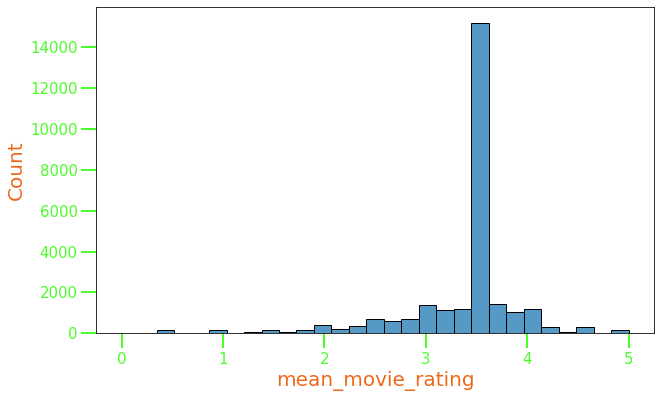

In [30]:
movies['mean_movie_rating'] = movies.movieId.map(
    ratings.groupby('movieId').rating.mean()
).fillna(ratings.rating.mean())

sns.histplot(movies.mean_movie_rating, bins=np.linspace(0, 5, 30))
plt.show()

Get movie release dates

In [31]:
import re

def title_feature_extraction(title):
    m = re.search(r"\(([0-9_]+)\)", title)
    return None if m is None else m.group(1)

In [32]:
movies['movie_year'] = movies.title \
                        .apply(title_feature_extraction) \
                        .apply(lambda x: None if x is None or int(x) < 1888 else int(x))

movies.isna().sum()

movieId               0
title                 0
genres                0
mean_movie_rating     0
movie_year           25
dtype: int64

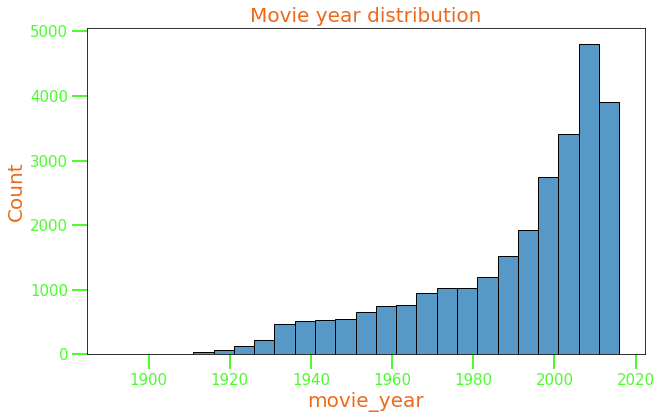

In [33]:
sns.histplot(movies.movie_year, bins=np.arange(1891, 2021, 5))

plt.title('Movie year distribution')
plt.show()

In [34]:
movies.movie_year = movies.movie_year.fillna(
    movies.movie_year.value_counts().index[0]
)

In [35]:
# a workaround drop_first to fix multicollinearity between genres
genres = movies.genres.str.get_dummies(sep='|').drop('(no genres listed)', axis=1)

genres.head()

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [36]:
movies = pd.concat(
    (movies, genres),
    axis=1
).drop('genres', axis=1)

movies.isna().sum().sum()

0

In [37]:
movies[genres.columns].sum()

Action          3520
Adventure       2329
Animation       1027
Children        1139
Comedy          8374
Crime           2939
Documentary     2471
Drama          13344
Fantasy         1412
Film-Noir        330
Horror          2611
IMAX             196
Musical         1036
Mystery         1514
Romance         4127
Sci-Fi          1743
Thriller        4178
War             1194
Western          676
dtype: int64

In [38]:
movies.title = movies.title.apply(
    lambda x:
        x.split('(')[0]
)

movies.head()

,movieId,title,mean_movie_rating,movie_year,Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story,3.951884,1995.0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji,3.264176,1995.0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men,3.192780,1995.0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale,3.026718,1995.0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II,3.144569,1995.0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


Apply TF-IDF to try to detect `title` components

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Ignore typical English words, numbers, 1-letter words
tf = TfidfVectorizer(token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b', stop_words='english')

df = pd.DataFrame(tf.fit_transform(movies.title).todense())
df.columns = tf.get_feature_names()

df.sample(5)

,10th,110th,11th,12th,13b,13hrs,13th,14th,19th,1st,...,école,époque,équipe,état,étoile,étudiante,öga,último,üvegtigris,貞子3d
1131,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23389,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20115,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7282,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3362,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


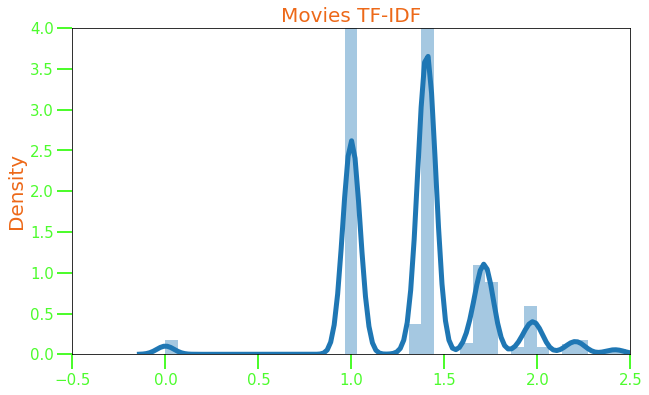

In [40]:
sns.distplot(df.sum(axis=1))

plt.xlim(-0.5, 2.5)
plt.ylim(0, 4)
plt.title('Movies TF-IDF')
plt.show()

Seems like movies can be separated into a few groups, according to their TF-IDF scores.

Topic modeling

In [41]:
movies.shape[0]

27278

In [42]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(max_df=0.9, min_df=2,
                             token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b',
                             stop_words='english')
matrix = count_vect.fit_transform(movies.title.values.astype('U'))

matrix

<27278x6019 sparse matrix of type '<class 'numpy.int64'>'
	with 46361 stored elements in Compressed Sparse Row format>

In [43]:
from sklearn.decomposition import LatentDirichletAllocation

LDA = LatentDirichletAllocation(n_components=2, random_state=3104)
LDA.fit(matrix)

LatentDirichletAllocation(n_components=2, random_state=3104)

In [44]:
for i,topic in enumerate(LDA.components_):
    print(f'Top 10 words for {i}-th topic:')
    print(' | '.join([count_vect.get_feature_names()[i] for i in topic.argsort()[-10:]]))
    print('\n')

Top 10 words for 0-th topic:
white | woman | death | little | house | s | dead | life | love | man


Top 10 words for 1-th topic:
t | night | american | world | time | girl | day | movie | story | s




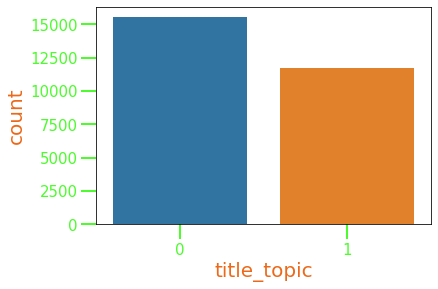

In [45]:
plt.figure(figsize=(6, 4))

movies['title_topic'] = LDA.transform(matrix).argmax(axis=1)
sns.countplot(movies.title_topic)
plt.show()

In [46]:
movies.movie_year = movies.movie_year.astype(np.int16)
movies = movies.drop('title', axis=1)
movies.head()

,movieId,mean_movie_rating,movie_year,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,title_topic
0,1,3.951884,1995,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2,3.264176,1995,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,3.192780,1995,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1
3,4,3.026718,1995,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1
4,5,3.144569,1995,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
movies.isna().sum().sum()

0

In [48]:
movies.shape[1]

23

<a id='clusters'></a>
### User clustering

In [49]:
ratings.columns

Index(['userId', 'movieId', 'rating', 'timestamp', 'mean_user_rating',
       'views_per_day', 'log_total_views', 'year', 'hour'],
      dtype='object')

In [50]:
users = ratings[
    ['userId', 'mean_user_rating', 'views_per_day', 'log_total_views']
].copy().drop_duplicates()

users.head()

,userId,mean_user_rating,views_per_day,log_total_views
0,4864,3.689655,0.667519,5.568345
9,3338,3.120301,1.546512,4.897840
44,3654,4.111111,0.454545,3.828641
71,1540,3.229167,48.000000,3.891820
119,751,3.857143,0.125000,3.091042


In [51]:
users.shape[0] == users.userId.nunique()

True

In [52]:
# !pip install umap-learn

In [53]:
import umap.umap_ as umap

X_users = users.drop(['userId'], axis=1)

umap_projection = umap.UMAP(random_state=3104).fit_transform(X_users)
umap_projection = pd.DataFrame(umap_projection, columns=['component_1', 'component_2'])

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


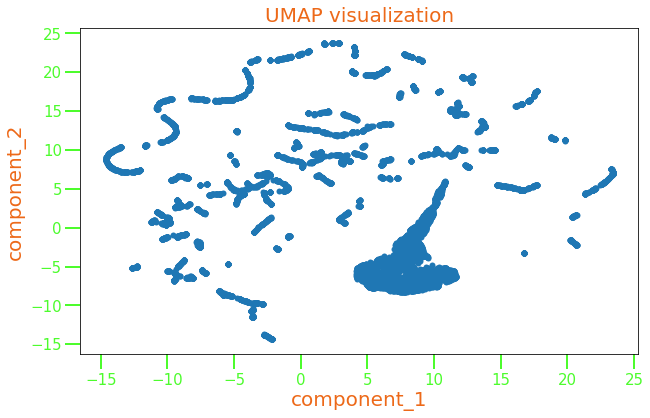

In [54]:
sns.scatterplot(x=umap_projection.component_1, y=umap_projection.component_2, linewidth=0)

plt.title('UMAP visualization')
plt.show()

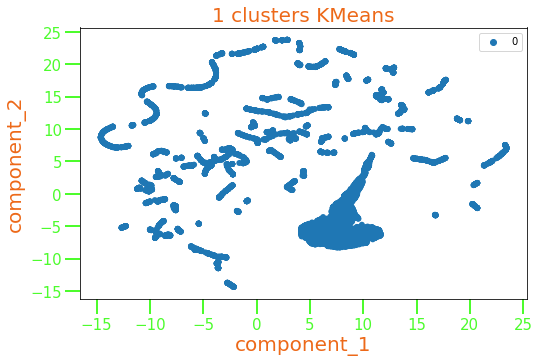

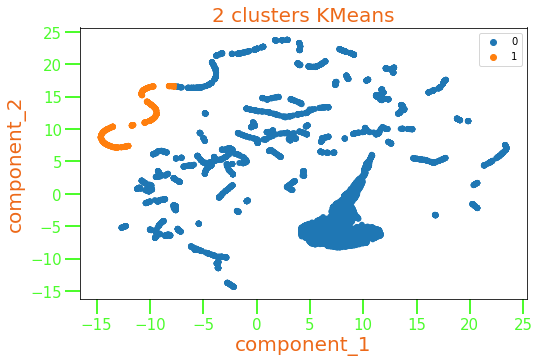

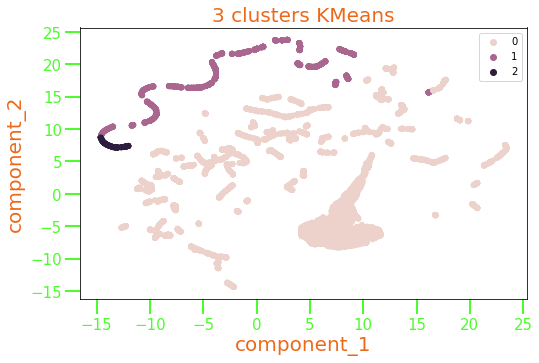

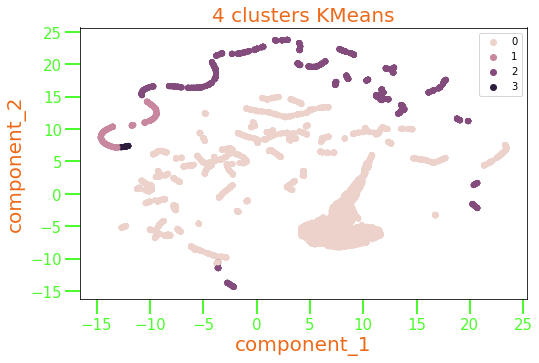

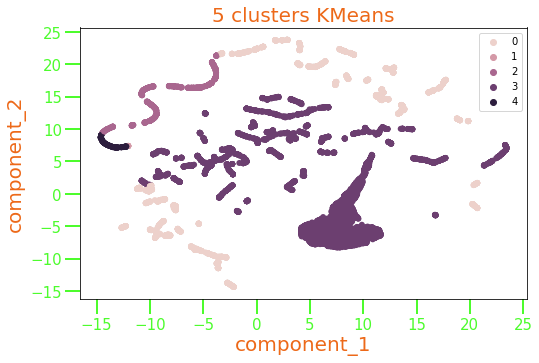

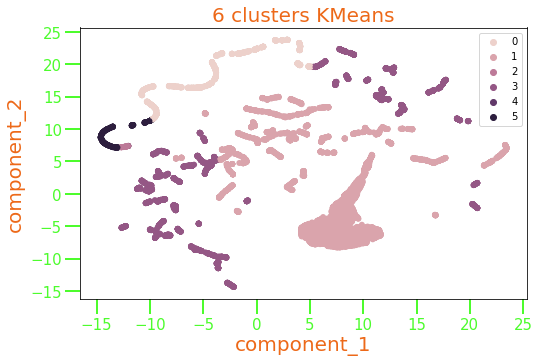

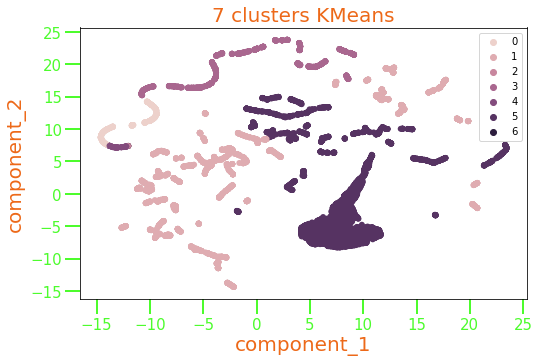

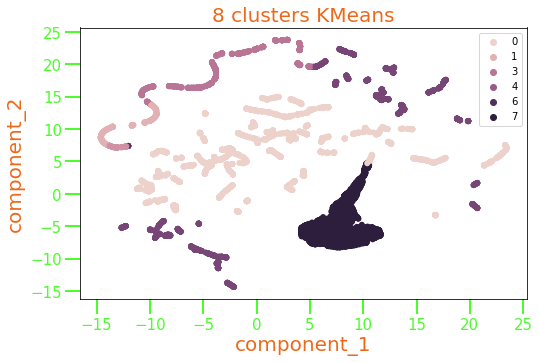

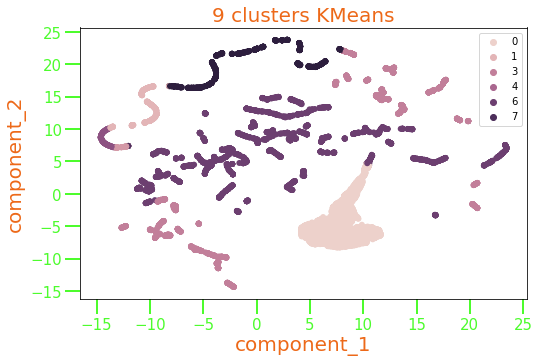

In [55]:
from sklearn.cluster import KMeans

for n_clusters in np.arange(1, 10, 1):
    segments = KMeans(n_clusters=n_clusters).fit_predict(X_users)

    plt.figure(figsize=(8, 5))
    sns.scatterplot(x='component_1', y='component_2',
                    hue=segments, data=umap_projection, linewidth=0)
    plt.title(f'{n_clusters} clusters KMeans')
    plt.show()

**KMeans** algorithm performs poorly, so we may try to use **DBSCAN** with some hyperparameter tuning

In [56]:
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(umap_projection)

X_scaled = pd.DataFrame(X_scaled, columns=['component_1', 'component_2'])

Finding the best hyperparameters for DBSCAN

In [57]:
X_scaled = X_scaled.sort_values(by=['component_1', 'component_2'])
df = pd.DataFrame(columns=['index', 'distance'])
for i in range(0, X_scaled.shape[0] - 1):
    dist = np.linalg.norm(X_scaled.iloc[i] - X_scaled.iloc[i + 1])
    df = df.append({'index': i, 'distance': dist}, ignore_index=True)
    
df = df.sort_values(by='distance')

df.head()

,index,distance
6397,6397.0,0.000004
1278,1278.0,0.000006
505,505.0,0.000007
1088,1088.0,0.000008
6616,6616.0,0.000008


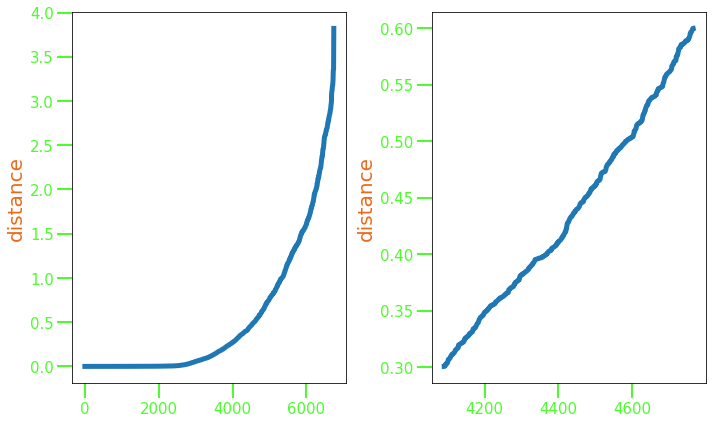

In [58]:
fig = plt.figure()
df.index = df.index.sort_values()

ax1 = fig.add_subplot(1, 2, 1)
sns.lineplot(x=df.index, y=df.distance)


df_2 = df[(df.distance >= 0.3) & (df.distance <= 0.6)]

ax2 = fig.add_subplot(1, 2, 2)
sns.lineplot(x=df_2.index, y=df_2.distance)


fig.tight_layout()
plt.show()

Detect the 'elbow' epsilon value 

In [59]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

epsilons = np.arange(0.5, 0.6, 0.02)

max_score = -float('inf')
best_eps = 0

for eps in epsilons:
    db = DBSCAN(eps=eps, min_samples=20).fit(X_scaled)
    core_sample_masks = np.zeros_like(db.labels_, dtype=bool)
    core_sample_masks[db.core_sample_indices_] = True
    
    labels = db.labels_
    if len(set(labels)) == 2:
        new_score = silhouette_score(X_scaled, labels)
        if max_score < new_score:
            max_score = new_score
            best_eps = eps
            print(set(labels), silhouette_score(X_scaled, labels), eps)

{0, 1} 0.17245145 0.5


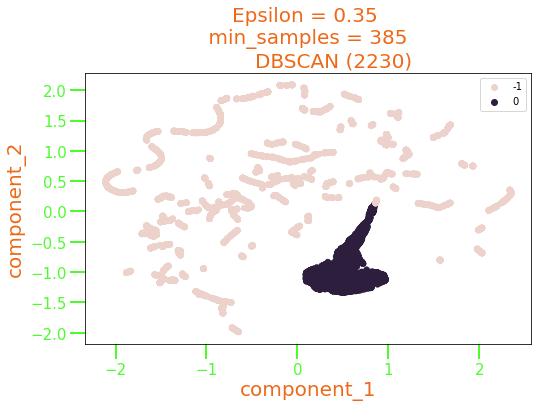

In [60]:
from itertools import product

# epsilons = np.arange(0.1, 5, 10)


epsilons = [0.35]
samples=[385]
# epsilons = np.linspace(0.357, 0.4, 100)

# samples = np.arange(460, 600, 10)

for eps, neighbours in product(epsilons, samples):
    
    dbscan = DBSCAN(eps=eps, min_samples=neighbours).fit(X_scaled)
    y = dbscan.labels_
    
    if len(set(y)) >= 2:
        plt.figure(figsize=(8, 5))
        sns.scatterplot(x='component_1', y='component_2', hue=y, data=X_scaled, edgecolor=None)

        plt.title(f"""Epsilon = {eps} \n min_samples = {neighbours} 
        DBSCAN ({np.count_nonzero(dbscan.labels_ == 0)})""")

        plt.show()

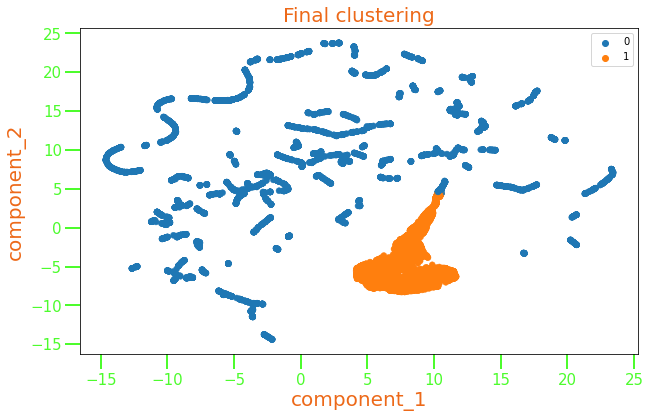

In [61]:
X_scaled = StandardScaler().fit_transform(umap_projection)
X_scaled = pd.DataFrame(X_scaled, columns=['component_1', 'component_2'])

db = DBSCAN(eps=0.5107, min_samples=775).fit(X_scaled)
users['user_cluster'] = db.labels_ + 1

sns.scatterplot(x=umap_projection.component_1, y=umap_projection.component_2, 
                hue=np.array(users.user_cluster), edgecolor=None)

plt.title('Final clustering')
plt.show()

In [62]:
users.to_csv('users.csv', index=False)

users.head()

,userId,mean_user_rating,views_per_day,log_total_views,user_cluster
0,4864,3.689655,0.667519,5.568345,1
9,3338,3.120301,1.546512,4.897840,1
44,3654,4.111111,0.454545,3.828641,1
71,1540,3.229167,48.000000,3.891820,0
119,751,3.857143,0.125000,3.091042,1


<a id='merge'></a>

#### Merge data

In [63]:
ratings.head(1)

,userId,movieId,rating,timestamp,mean_user_rating,views_per_day,log_total_views,year,hour
0,4864,79,1.0,1996-02-28 09:32:14,3.689655,0.667519,5.568345,1996,9


In [64]:
movies.head(1)

,movieId,mean_movie_rating,movie_year,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,title_topic
0,1,3.951884,1995,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [65]:
users.head(1)

,userId,mean_user_rating,views_per_day,log_total_views,user_cluster
0,4864,3.689655,0.667519,5.568345,1


In [66]:
df = pd.merge(
    ratings, movies, 
    on='movieId',
    how='left'
)

df = pd.merge(
    df, users[['userId', 'user_cluster']],
    how='left'
)

df.head()

,userId,movieId,rating,timestamp,mean_user_rating,views_per_day,log_total_views,year,hour,mean_movie_rating,...,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,title_topic,user_cluster
0,4864,79,1.0,1996-02-28 09:32:14,3.689655,0.667519,5.568345,1996,9,3.211744,...,0,0,0,0,0,1,0,0,0,1
1,4864,17,5.0,1996-02-28 09:32:14,3.689655,0.667519,5.568345,1996,9,3.937083,...,0,0,0,1,0,0,0,0,1,1
2,4864,10,3.0,1996-02-28 09:32:14,3.689655,0.667519,5.568345,1996,9,3.422635,...,0,0,0,0,0,1,0,0,0,1
3,4864,11,5.0,1996-02-28 09:32:14,3.689655,0.667519,5.568345,1996,9,3.710035,...,0,0,0,1,0,0,0,0,1,1
4,4864,92,2.0,1996-02-28 09:32:15,3.689655,0.667519,5.568345,1996,9,2.794118,...,0,0,0,0,0,1,0,0,0,1


In [67]:
df.shape[0] == 1e6

True

In [68]:
df['view_delta'] = df.timestamp.dt.year - df.movie_year

df.head(1)

,userId,movieId,rating,timestamp,mean_user_rating,views_per_day,log_total_views,year,hour,mean_movie_rating,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,title_topic,user_cluster,view_delta
0,4864,79,1.0,1996-02-28 09:32:14,3.689655,0.667519,5.568345,1996,9,3.211744,...,0,0,0,0,1,0,0,0,1,0


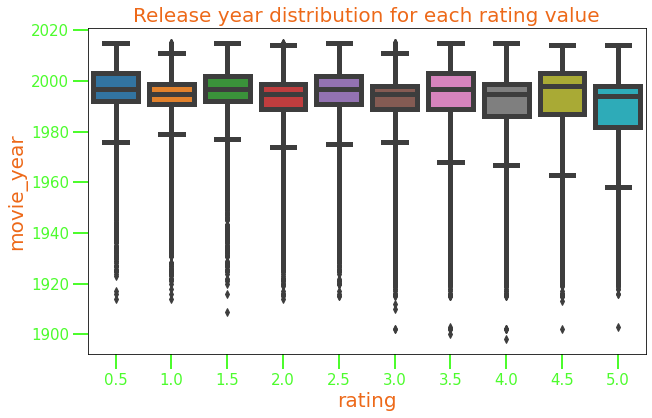

In [69]:
sns.boxplot(x=df.rating, y=df.movie_year)

plt.title('Release year distribution for each rating value')
plt.show()

In [70]:
# sns.boxplot(x=df.rating, y=df.movie_tf_idf_sum)

# plt.title('TF-IDF score for each rating')
# plt.show()

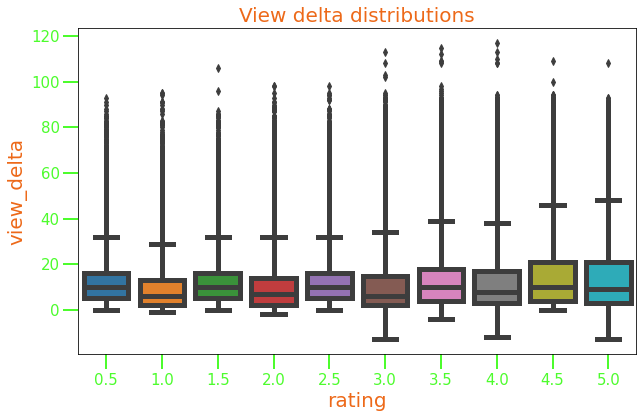

In [71]:
sns.boxplot(x=df.rating, y=df.view_delta)

plt.title('View delta distributions')
plt.show()

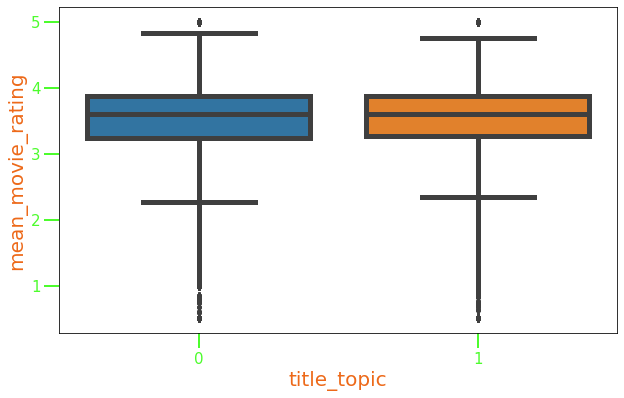

In [96]:
sns.boxplot(x=df.title_topic, y=df.mean_movie_rating)

plt.show()

In [73]:
cat_features = ['year', 'hour', 'movie_year', 'user_cluster', 'title_topic']
num_features = ['rating', 'mean_user_rating', 'mean_movie_rating', 
                'views_per_day', 'log_total_views', 'view_delta']

In [74]:
no_genres = df.drop(genres.columns, axis=1)

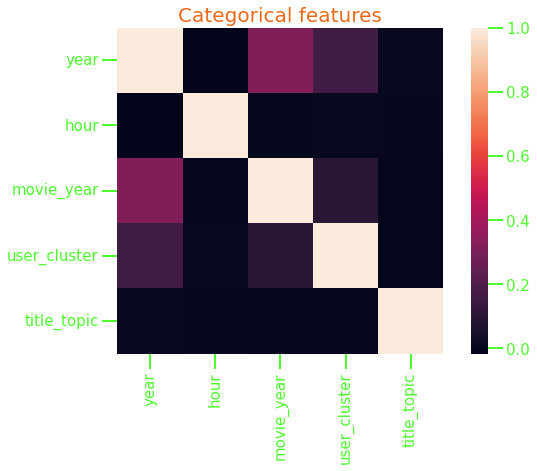

In [75]:
sns.heatmap(no_genres[cat_features].corr(method='spearman'), square=True)

plt.title('Categorical features')
plt.show()

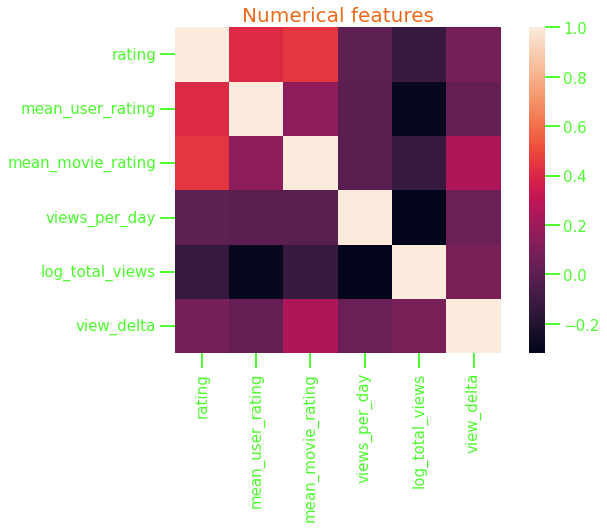

In [76]:
sns.heatmap(no_genres[num_features].corr(method='spearman'), square=True)

plt.title('Numerical features')
plt.show()

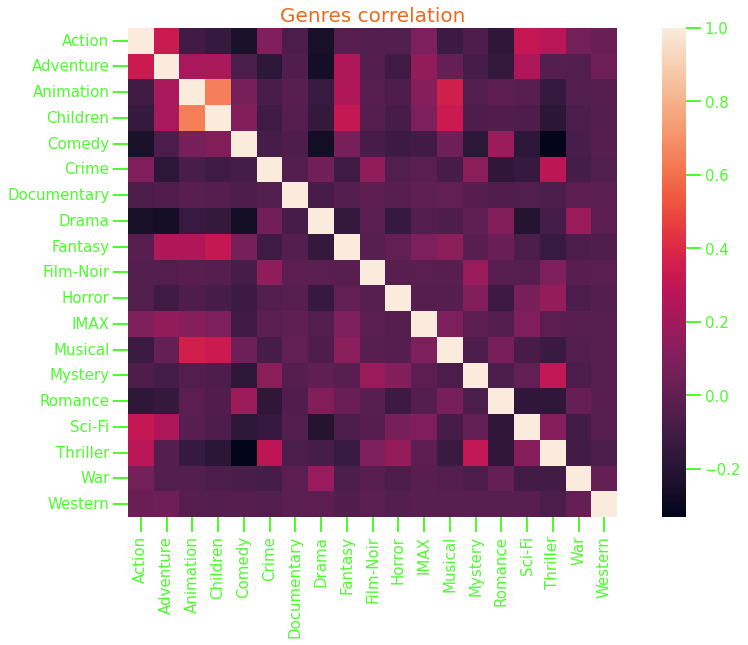

In [77]:
plt.figure(figsize=(16, 9))
sns.heatmap(df[genres.columns].corr(method='spearman'), square=True)

plt.title('Genres correlation')
plt.show()

In [78]:
df[genres.columns].corr(method='spearman').loc['Children']['Animation']

0.6449619749512656

**Children** and **Animation** are correlated, which is common sense

<a id='importances'></a>
### Initial feature importances 

<a id='linreg'></a>
#### Linear Regression

In [79]:
df_ = df.copy().drop('timestamp', axis=1)

df_.head()

,userId,movieId,rating,mean_user_rating,views_per_day,log_total_views,year,hour,mean_movie_rating,movie_year,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,title_topic,user_cluster,view_delta
0,4864,79,1.0,3.689655,0.667519,5.568345,1996,9,3.211744,1996,...,0,0,0,0,1,0,0,0,1,0
1,4864,17,5.0,3.689655,0.667519,5.568345,1996,9,3.937083,1995,...,0,0,1,0,0,0,0,1,1,1
2,4864,10,3.0,3.689655,0.667519,5.568345,1996,9,3.422635,1995,...,0,0,0,0,1,0,0,0,1,1
3,4864,11,5.0,3.689655,0.667519,5.568345,1996,9,3.710035,1995,...,0,0,1,0,0,0,0,1,1,1
4,4864,92,2.0,3.689655,0.667519,5.568345,1996,9,2.794118,1996,...,0,0,0,0,1,0,0,0,1,0


In [80]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

X, y = df_.drop(['userId', 'movieId', 'rating'], axis=1), df_.rating
X_ = StandardScaler().fit_transform(X)

model = LinearRegression()
model.fit(X_, y)

LinearRegression()

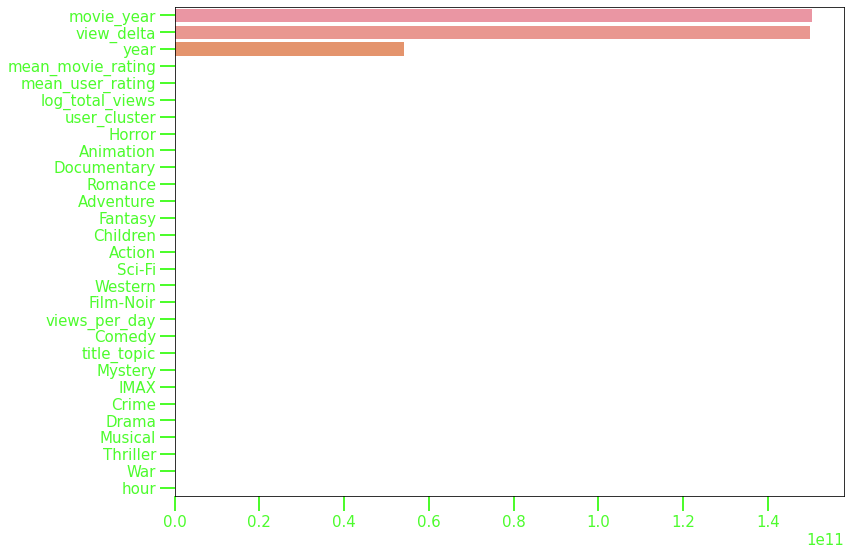

In [81]:
plt.figure(figsize=(12, 9))

importances = abs(model.coef_)
indices = np.flip(np.argsort(importances))

sns.barplot(y=[X.columns[i] for i in indices], x=importances[indices])
plt.show()

<a id='tree'></a>
#### Decision Tree Regressor

In [82]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor()
model.fit(X_, y)

DecisionTreeRegressor()

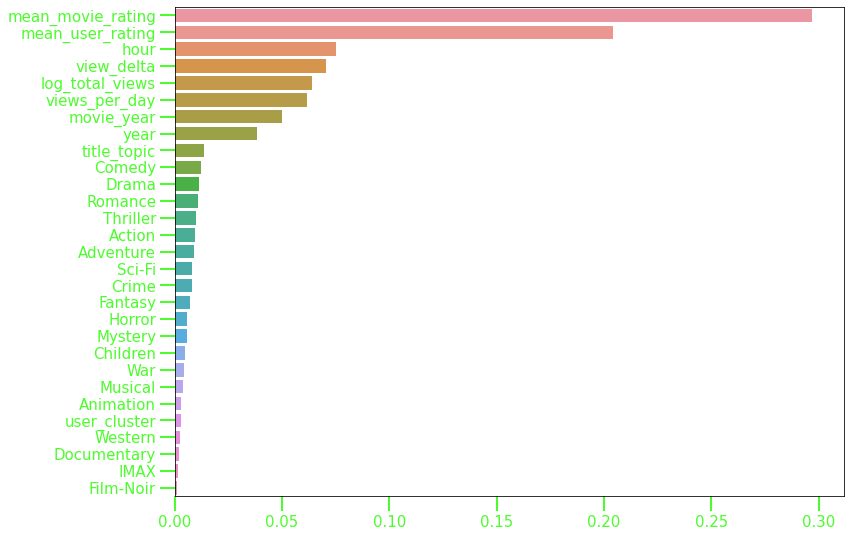

In [83]:
plt.figure(figsize=(12, 9))

importances = abs(model.feature_importances_)
indices = np.flip(np.argsort(importances))

sns.barplot(y=[X.columns[i] for i in indices], x=importances[indices])
plt.show()

In [84]:
from sklearn.feature_selection import VarianceThreshold

v = VarianceThreshold().fit(X)
if v.get_feature_names_out().size == X.shape[1]:
    print('All of the features have variance higher than a threshold')
else:
    print(f'{X.shape[1] - v.get_feature_names_out().size} columns must be analyzed')

All of the features have variance higher than a threshold


<a id='models'></a>
### Modeling

In [85]:
df.head()

,userId,movieId,rating,timestamp,mean_user_rating,views_per_day,log_total_views,year,hour,mean_movie_rating,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,title_topic,user_cluster,view_delta
0,4864,79,1.0,1996-02-28 09:32:14,3.689655,0.667519,5.568345,1996,9,3.211744,...,0,0,0,0,1,0,0,0,1,0
1,4864,17,5.0,1996-02-28 09:32:14,3.689655,0.667519,5.568345,1996,9,3.937083,...,0,0,1,0,0,0,0,1,1,1
2,4864,10,3.0,1996-02-28 09:32:14,3.689655,0.667519,5.568345,1996,9,3.422635,...,0,0,0,0,1,0,0,0,1,1
3,4864,11,5.0,1996-02-28 09:32:14,3.689655,0.667519,5.568345,1996,9,3.710035,...,0,0,1,0,0,0,0,1,1,1
4,4864,92,2.0,1996-02-28 09:32:15,3.689655,0.667519,5.568345,1996,9,2.794118,...,0,0,0,0,1,0,0,0,1,0


In [86]:
df_ = df.sort_values(by='timestamp') \
    .drop(['userId', 'movieId', 'timestamp', 'year'], axis=1)
df_ = pd.concat(
    (df_.drop('title_topic', axis=1), 
         pd.get_dummies(df_.title_topic, prefix='title',  drop_first=True)),
    axis=1
)

df_.head()

,rating,mean_user_rating,views_per_day,log_total_views,hour,mean_movie_rating,movie_year,Action,Adventure,Animation,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,user_cluster,view_delta,title_1
0,1.0,3.689655,0.667519,5.568345,9,3.211744,1996,0,0,0,...,0,0,0,0,1,0,0,1,0,0
1,5.0,3.689655,0.667519,5.568345,9,3.937083,1995,0,0,0,...,0,0,1,0,0,0,0,1,1,1
2,3.0,3.689655,0.667519,5.568345,9,3.422635,1995,1,1,0,...,0,0,0,0,1,0,0,1,1,0
3,5.0,3.689655,0.667519,5.568345,9,3.710035,1995,0,0,0,...,0,0,1,0,0,0,0,1,1,1
4,2.0,3.689655,0.667519,5.568345,9,2.794118,1996,0,0,0,...,0,0,0,0,1,0,0,1,0,0


In [87]:
len(df_.loc[:, df_.dtypes != object].columns) == df_.shape[1]

True

In [88]:
train = df_[:-100000]
test = df_[-100000:]
X, y = df_.drop('rating', axis=1), df_.rating

X_train, y_train = train.drop('rating', axis=1), train.rating
X_test, y_test = test.drop('rating', axis=1), test.rating

print(train.shape, test.shape)

(900000, 29) (100000, 29)


<a id='metric'></a>
#### Metric choice

In [89]:
from sklearn.metrics import mean_squared_error

def rmse(y, pred):
    return mean_squared_error(y, pred, squared=False)

<a id='rf'></a>
#### Random Forest 

In [90]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV


# model = RandomForestRegressor()
# params_rf = {
#     'max_depth': range(1, 41, 5),
#     'n_estimators': range(10, 51, 10),
#     'min_samples_leaf': range(10, 91, 20),
#     'min_samples_split': range(10, 91, 20)
# }

# cv = GridSearchCV(estimator=model,
#                   param_grid=params_rf,
# #                   scoring=rmse,
#                   cv=TimeSeriesSplit(),
#                   n_jobs=-1,
#                   verbose=10,
#                   error_score="raise"
#                  )

# cv = RandomizedSearchCV(
#                   estimator=model,
#                   param_distributions=params_rf,
# #                   scoring=rmse,
#                   cv=TimeSeriesSplit(),
#                   n_jobs=-1,
#                   verbose=10,
#                   error_score="raise"
#                  )

# cv.fit(X_train, y_train)
# cv.best_params_

In [91]:
forest = RandomForestRegressor(
    max_depth=16,
    min_samples_leaf=10,
    min_samples_split=10,
    n_estimators=30
)

forest.fit(X_train, y_train)

RandomForestRegressor(max_depth=16, min_samples_leaf=10, min_samples_split=10,
                      n_estimators=30)

In [92]:
print(f'Train RF RMSE:\t{rmse(forest.predict(X_train), y_train)}')
print(f'Test RF RMSE:\t{rmse(forest.predict(X_test), y_test)}')
print(f'Overall RF RMSE:\t{rmse(forest.predict(X), y)}')

Train RF RMSE:	0.7873617906142805
Test RF RMSE:	0.8199519728373597
Overall RF RMSE:	0.7906812595245832


<a id='cat'></a>
#### Catboost

In [93]:
X.columns

Index(['mean_user_rating', 'views_per_day', 'log_total_views', 'hour',
       'mean_movie_rating', 'movie_year', 'Action', 'Adventure', 'Animation',
       'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
       'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance',
       'Sci-Fi', 'Thriller', 'War', 'Western', 'user_cluster', 'view_delta',
       'title_1'],
      dtype='object')

In [94]:
df.columns

Index(['userId', 'movieId', 'rating', 'timestamp', 'mean_user_rating',
       'views_per_day', 'log_total_views', 'year', 'hour', 'mean_movie_rating',
       'movie_year', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
       'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
       'Western', 'title_topic', 'user_cluster', 'view_delta'],
      dtype='object')

In [99]:
df_ = df.sort_values(by='timestamp') \
        .drop(['userId', 'movieId', 'timestamp', 'year'], axis=1)
df_.movie_year = df_.movie_year.astype(np.int16)

train = df_[:-100000]
test = df_[-100000:]

X_train, y_train = train.drop('rating', axis=1), train.rating
X_test, y_test = test.drop('rating', axis=1), test.rating

X = pd.concat(
    (X_train, X_test),
    axis=0
)
y = y_train.append(y_test)

# NB: check 
cat_cols = ['hour', 'movie_year', 'Action', 'Adventure', 'Animation', 'Children',
            'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
            'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller',
            'War', 'Western', 'title_topic', 'user_cluster']

In [100]:
from catboost import CatBoostRegressor

boost = CatBoostRegressor(loss_function='RMSE', cat_features=cat_cols)
boost.fit(X_train, y_train,
          eval_set=(X_test, y_test),
          early_stopping_rounds=50,
          silent=True,
          plot=True
         )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [101]:
print(f'Train GB RMSE:\t{rmse(boost.predict(X_train), y_train)}')
print(f'Test GB RMSE:\t{rmse(boost.predict(X_test), y_test)}')
print(f'Overall GB RMSE:\t{rmse(boost.predict(X), y)}')

Train GB RMSE:	0.8529374732929388
Test GB RMSE:	0.8166171198724047
Overall GB RMSE:	0.849375330498525


In [ ]:
# boost_ = CatBoostRegressor(loss_function='RMSE', cat_features=cat_cols)

# params_gb = {
#     'depth': range(5, 11, 1),
#     'learning_rate': np.linspace(0.1, 0.5, 5),
#     'iterations': range(10, 101 , 10)
# }

# cv = RandomizedSearchCV(
#                   estimator=boost_,
#                   param_distributions=params_gb,
# #                   scoring=rmse,
#                   cv=TimeSeriesSplit(),
#                   n_jobs=-1,
#                   error_score="raise"
#                  )
# cv.fit(X_train, y_train)

# print(cv.best_score_)
# print(cv.best_params_)

In [102]:
boost = CatBoostRegressor(
    learning_rate=0.07,
    iterations=220,
    depth=14,
    loss_function='RMSE',
    cat_features=cat_cols
)

boost.fit(X_train, y_train,
          eval_set=(X_test, y_test),
          silent=True, 
          plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [103]:
print(f'Train GB RMSE:\t{rmse(boost.predict(X_train), y_train)}')
print(f'Test GB RMSE:\t{rmse(boost.predict(X_test), y_test)}')
print(f'Overall GB RMSE:\t{rmse(boost.predict(X), y)}')

Train GB RMSE:	0.8245138776794511
Test GB RMSE:	0.8152500422913113
Overall GB RMSE:	0.823592183172596


In [104]:
boost.save_model('catboost_model', format="cbm")

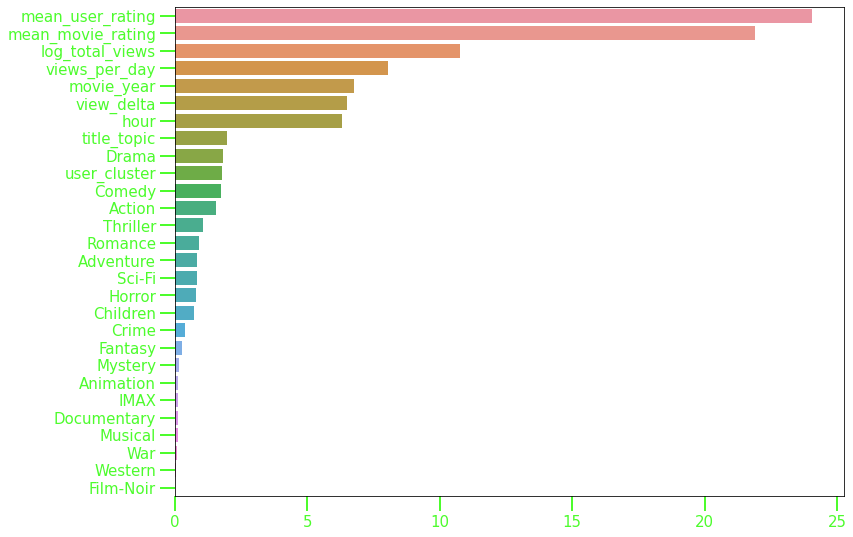

In [105]:
plt.figure(figsize=(12, 9))

importances = abs(boost.get_feature_importance())
indices = np.flip(np.argsort(importances))

sns.barplot(y=[boost.feature_names_[i] for i in indices], x=importances[indices])
plt.show()

<a id='example'></a>
### Usage example

In [106]:
def make_predictions(user_id, timestamp, M=10000, k=10):
    user_background = ratings[ratings.userId == user_id]
    
    samples = movies[~(movies.movieId.isin(user_background))].sample(M)
    samples[users.columns] = users[users.userId == user_id].iloc[0]
    samples = samples.drop('userId', axis=1)


    samples['view_delta'] = timestamp.year - samples.movie_year
    samples['hour'] = timestamp.hour
    samples.user_cluster = samples.user_cluster.astype(np.int16)
    
    samples['prediction'] = boost.predict(samples[boost.feature_names_])
    
    return np.array(samples.sort_values(by='prediction', ascending=False).iloc[:k].movieId)

In [109]:
import datetime

user_id = 228
timestamp = datetime.datetime.now()

print('Movie ids to watch:\t', make_predictions(user_id=user_id, timestamp=timestamp))

Movie ids to watch:	 [  6160  99889  78140  91927   6167  79850   8663  48001  44115 128832]
